In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import itertools

from urllib import request
from bs4 import BeautifulSoup

import nltk, re, pprint
from nltk import word_tokenize, sent_tokenize

from nltk.util import ngrams

from nltk.stem.lancaster import LancasterStemmer
from nltk.stem.porter import PorterStemmer

from nltk.stem import WordNetLemmatizer

from nltk.probability import FreqDist

from nltk.corpus import stopwords

from nltk.tag import pos_tag

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.cluster import KMeans

from sklearn.decomposition import NMF
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

from textblob import TextBlob, Word
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

import scattertext as st

from corextopic import corextopic as ct
from corextopic import vis_topic as vt

import gensim

## Read HTML Data and perform basic cleaning

In [3]:
url_buddha = "https://www.gutenberg.org/files/35895/35895-0.txt"
url_kingjames = "http://www.gutenberg.org/cache/epub/10900/pg10900.txt"
url_koran = "http://www.gutenberg.org/cache/epub/3434/pg3434.txt"
url_mormon = "http://www.gutenberg.org/cache/epub/17/pg17.txt"

In [4]:
response_buddha = request.urlopen(url_buddha)
response_james = request.urlopen(url_kingjames)
response_koran = request.urlopen(url_koran)
response_mormon = request.urlopen(url_mormon)

In [5]:
buddha = response_buddha.read().decode('utf8')
king_james = response_james.read().decode('utf8')
koran = response_koran.read().decode('utf8')
mormon = response_mormon.read().decode('utf8')

### Split King James Bible into Old and New Testaments

In [6]:
# Old Testament

old_testament = king_james[:3427088]

In [7]:
# New Testament

new_testament = king_james[3427088:]

### Remove header and footer

In [8]:
# Gospel of Buddha

for match in re.finditer('REJOICE', buddha):
    text_start = match.end()

for match in re.finditer('End of the Project Gutenberg EBook', buddha):
    text_end = match.start()

    buddha = buddha[text_start:text_end]

In [9]:
# Book of Mormon

for match in re.finditer('START OF THIS PROJECT GUTENBERG EBOOK', mormon):
    text_start = match.end()

for match in re.finditer('End of the Project Gutenberg EBook', mormon):
    text_end = match.start()

    mormon = mormon[text_start:text_end]

In [10]:
# Koran

for match in re.finditer('START OF THIS PROJECT GUTENBERG EBOOK', koran):
    text_start = match.end()

for match in re.finditer('End of the Project Gutenberg EBook', koran):
    text_end = match.start()

    koran = koran[text_start:text_end]

In [11]:
# Old Testament

for match in re.finditer('START OF THIS PROJECT GUTENBERG EBOOK', old_testament):
    text_start = match.end()

    old_testament = old_testament[text_start:]

In [12]:
# New Testament

for match in re.finditer('End of Project Gutenberg', new_testament):
    text_end = match.start()

    new_testament = new_testament[:text_end]

## Tokenize

### Build 'master' corpus: each holy book is included to analyze common religious themes

In [13]:
all_holy_text = [buddha + mormon + old_testament + new_testament + koran] 
all_holy_text = ' '.join(all_holy_text)

#### Clean corpus

In [14]:
clean_text = re.sub('[%s]' % re.escape(string.punctuation), ' ', all_holy_text) # remove punctuation
clean_text = clean_text.lower() # convert to lower case
clean_text = re.sub('\w*\dw*', ' ', clean_text) # alphanumerics
clean_text = re.sub('[\r][\n][\t]', ' ', clean_text) # remove characters 

#### Tokenize Corpus

In [15]:
clean_tokens = word_tokenize(clean_text)

#### Remove old english

In [16]:
new_clean_tokens = []
    
for token in clean_tokens:
    if token.endswith('eth'):
        new_clean_tokens.append(token[:-4])
    else:
        new_clean_tokens.append(token)

### Build separate corpus': each holy book is its own corpus to identify distinct themes

#### Clean each book

In [17]:
# basic cleaning of each holy book

def clean_text(text):
    clean_book = re.sub('[%s]' % re.escape(string.punctuation), ' ', text) # remove punctuation
    clean_book = clean_book.lower() # convert to lower case
    clean_book = re.sub('\w*\dw*', ' ', clean_book) # alphanumerics
    clean_book = re.sub('[\r][\n][\t]', ' ', clean_book) # remove characters
    
    return clean_book

clean_buddha = clean_text(buddha)
clean_old_testament = clean_text(old_testament)
clean_new_testament = clean_text(new_testament)
clean_koran = clean_text(koran)
clean_mormon = clean_text(mormon)

#### Tokenize by book

In [18]:
buddha_tokens = word_tokenize(clean_buddha)
old_testament_tokens = word_tokenize(clean_old_testament)
new_testament_tokens = word_tokenize(clean_new_testament)
koran_tokens = word_tokenize(clean_koran)
mormon_tokens = word_tokenize(clean_mormon)

In [19]:
# Remove old english for more robust sentiment analysis

def remove_old_english(l):

    new_tokens= []
    
    for token in l:
        if token.endswith('eth'):
            new_tokens.append(token[:-4])
        else:
            new_tokens.append(token)
           
    return new_tokens
            
buddha_tokens = remove_old_english(buddha_tokens)
old_testament_tokens = remove_old_english(old_testament_tokens)
new_testament_tokens = remove_old_english(new_testament_tokens)
koran_tokens = remove_old_english(koran_tokens)
mormon_tokens = remove_old_english(mormon_tokens)

## Lemmatize

In [20]:
lemmatizer = WordNetLemmatizer()

### Lemmatize entire corpus

In [21]:
lemmatized_list = [lemmatizer.lemmatize(word) for word in new_clean_tokens]

### Lemmatize By Book

In [22]:
def lemmatize(text):
    
    lemmatized_list_by_book = [lemmatizer.lemmatize(word) for word in text]
    return lemmatized_list_by_book

lemmatized_buddha_list = lemmatize(buddha_tokens)
lemmatized_old_testament_list = lemmatize(old_testament_tokens)
lemmatized_new_testament_list = lemmatize(new_testament_tokens)
lemmatized_koran_list = lemmatize(koran_tokens)
lemmatized_mormon_list = lemmatize(mormon_tokens)

## TFIDF

### Stop Words

In [23]:
# standard english stop words as well as custom old english stop words

stop_words = stopwords.words('english')

new_stop_words = ['ye', 'thee', 'let', 'thy', 'thou', 'hath', 'unto', 'skt', 'say', 'thing',
                  'go', 'come', 'god', 'also', 'lord', 'one', 'buddha', 'jesus', 'christ',
                 'nephi', 'muhammad', 'day', 'father', 'son', 'man', 'upon', 'koran',
                 'yea', 'men', 'lamanites', 'nephites', 'said', 'moroni', 'uruvela',
                 'mosiah', 'helaman', 'xiii', 'xxvi', 'fo', 'pp', 'vv', 'mv', 'iv', 'ii', 'iii',
                 'wherefore', 'sb', 'qkm', 'et', 'mpn', 'bst', 'gutenberg', 'project', 'agreement',
                 'rhdb', 'xii', 'sec', 'seq', 'matth', 'chd', 'xvii', 'saith', 'hast', 'thus', 'thine',
                 'art', 'doth', 'wherefore', 'thither', 'wast', 'hence']

In [24]:
stop_words.extend(new_stop_words)

### Vectorize 'master' corpus

In [25]:
# Document length of 100 characters proved most effective for topic modeling

documents = [lemmatized_list[i:i+100] for i in range(0, len(lemmatized_list), 100)]

document_list = []

for i in documents:
    document_list.append(' '.join(i))

In [26]:
 vectorizer = TfidfVectorizer(stop_words=stop_words, 
                             strip_accents='ascii', 
                             max_df=.2,
                             min_df=200,
                             token_pattern='[a-zA-Z0-9]{3,}')
    
X_ = vectorizer.fit_transform(document_list)
X = pd.DataFrame(X_.toarray(), columns=vectorizer.get_feature_names()) 

In [27]:
words = vectorizer.get_feature_names()

### Vectorize each distinct corpus

#### Split up each book into sections

In [28]:
# Document length of 100 characters proved most effective for topic modeling

buddha_documents = [lemmatized_buddha_list[i:i+100] for i in range(0, len(lemmatized_buddha_list), 100)]
old_testament_documents = [lemmatized_old_testament_list[i:i+100] for i in range(0, len(lemmatized_old_testament_list), 100)]
new_testament_documents = [lemmatized_new_testament_list[i:i+100] for i in range(0, len(lemmatized_new_testament_list), 100)]
koran_documents = [lemmatized_koran_list[i:i+100] for i in range(0, len(lemmatized_koran_list), 100)]
mormon_documents = [lemmatized_mormon_list[i:i+100] for i in range(0, len(lemmatized_mormon_list), 100)]

In [29]:
document_list_buddha = []
for doc in buddha_documents:
    document_list_buddha.append(' '.join(doc))

In [30]:
document_list_old_testament = []
for doc in old_testament_documents:
    document_list_old_testament.append(' '.join(doc))

In [31]:
document_list_new_testament = []
for doc in new_testament_documents:
    document_list_new_testament.append(' '.join(doc))

document_list_new_testament = document_list_new_testament[:-31] # Remove website endnotes

In [32]:
document_list_koran = []
for doc in koran_documents:
    document_list_koran.append(' '.join(doc))

document_list_koran = document_list_koran[:-21] # Remove website endnotes

In [33]:
document_list_mormon = []
for doc in mormon_documents:
    document_list_mormon.append(' '.join(doc))

#### Vectorize each holy book

##### Gospel of Buddha

In [34]:
vectorizer_buddha = TfidfVectorizer(stop_words=stop_words, 
                                    strip_accents='ascii', 
                                    max_df=.25,
                                    min_df=20,
                                    token_pattern='[a-zA-Z0-9]{3,}')

X_buddha_ = vectorizer_buddha.fit_transform(document_list_buddha)
X_buddha = pd.DataFrame(X_buddha_.toarray(), columns=vectorizer_buddha.get_feature_names()) 

In [35]:
buddha_words = vectorizer_buddha.get_feature_names()

##### Old Testament

In [36]:
vectorizer_old_testament = TfidfVectorizer(stop_words=stop_words, 
                                           strip_accents='ascii', 
                                           max_df=.15,
                                           min_df=20,
                                          token_pattern='[a-zA-Z0-9]{3,}')

X_old_testament = vectorizer_old_testament.fit_transform(document_list_old_testament)
X_old_testament = pd.DataFrame(X_old_testament.toarray(), columns=vectorizer_old_testament.get_feature_names()) 

In [37]:
old_testament_words = vectorizer_old_testament.get_feature_names()

##### New Testament

In [38]:
vectorizer_new_testament = TfidfVectorizer(stop_words=stop_words, 
                                           strip_accents='ascii', 
                                           max_df=.1,
                                           min_df=20,
                                           token_pattern='[a-zA-Z0-9]{3,}')

X_new_testament_ = vectorizer_new_testament.fit_transform(document_list_new_testament)
X_new_testament = pd.DataFrame(X_new_testament_.toarray(), columns=vectorizer_new_testament.get_feature_names()) 

In [39]:
new_testament_words = vectorizer_new_testament.get_feature_names()

##### Koran

In [40]:
vectorizer_koran = TfidfVectorizer(stop_words=stop_words, 
                                   strip_accents='ascii', 
                                   max_df=.1,
                                   min_df=20,
                                   token_pattern='[a-zA-Z0-9]{3,}')

X_koran = vectorizer_koran.fit_transform(document_list_koran)
X_koran = pd.DataFrame(X_koran.toarray(), columns=vectorizer_koran.get_feature_names()) 

In [41]:
koran_words = vectorizer_koran.get_feature_names()

##### Book of Mormon

In [42]:
vectorizer_mormon = TfidfVectorizer(stop_words=stop_words, 
                                    strip_accents='ascii', 
                                    max_df=.15,
                                    min_df=20,
                                    token_pattern='[a-zA-Z0-9]{3,}')
X_mormon = vectorizer_mormon.fit_transform(document_list_mormon)
X_mormon = pd.DataFrame(X_mormon.toarray(), columns=vectorizer_mormon.get_feature_names()) 

In [43]:
mormon_words = vectorizer_mormon.get_feature_names()

## Topic Modeling

### Topic model master corpus

In [44]:
model = NMF(n_components=10) # 10 topics
W = model.fit_transform(X)
H = model.components_

In [45]:
# Inspect relative strength of each topic

doc_cluster = W.argmax(axis = 1)
pd.Series(doc_cluster).value_counts()

0    3140
9    2807
6    1613
1    1210
3    1030
7     953
2     826
5     764
8     635
4     582
dtype: int64

In [46]:
topic_words = []
for r in H:
    a = sorted([(v,i) for i,v in enumerate(r)],reverse=True)[0:20] # 20 words per topic, sorted by relevance
    topic_words.append([words[e[1]] for e in a])

pd.DataFrame(topic_words)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,earth,heaven,good,truth,may,life,heart,evil,like,believe,verily,work,world,yet,fear,way,blessed,made,sign,know
1,israel,child,moses,tribe,congregation,aaron,spake,among,saying,inheritance,egypt,commanded,according,covenant,pharaoh,family,tabernacle,judah,thousand,name
2,alma,behold,pas,army,would,began,therefore,church,might,city,many,judge,according,forth,war,brother,great,power,could,exceedingly
3,king,judah,servant,babylon,israel,year,jerusalem,prince,sent,reign,kingdom,made,hand,answered,book,written,throne,prophet,priest,gold
4,offering,burnt,priest,altar,offer,sacrifice,sin,meat,fire,aaron,holy,congregation,tabernacle,made,blood,two,thereof,first,peace,year
5,shalt,make,put,take,hand,eat,neither,thereof,thyself,give,set,wife,daughter,surely,bring,eye,keep,die,place,bread
6,house,david,city,went,took,jerusalem,hand,judah,two,servant,place,hundred,thousand,brought,made,three,priest,thereof,daughter,gate
7,land,pas,year,egypt,wilderness,city,many,sea,great,began,forth,face,brought,army,nation,even,exceedingly,pharaoh,among,dwell
8,sura,see,verse,name,merciful,book,jew,called,prophet,first,year,part,wife,two,may,well,would,angel,whose,word
9,word,behold,brother,saying,pas,many,know,even,according,speak,prophet,spoken,spake,concerning,jacob,spirit,would,therefore,time,heard


### Topic model each distinct corpus 

#### Gospel of Buddha Topic Modeling

In [47]:
model_buddha = NMF(n_components=10)
W_buddha = model_buddha.fit_transform(X_buddha)
H_buddha = model_buddha.components_

In [48]:
doc_cluster_buddha = W_buddha.argmax(axis = 1)
pd.Series(doc_cluster_buddha).value_counts()

9    149
0    104
7    102
8     89
4     84
5     82
2     77
6     75
3     46
1     22
dtype: int64

In [49]:
topic_words_buddha = []
for r in H_buddha:
    a = sorted([(v,i) for i,v in enumerate(r)],reverse=True)[0:20]
    topic_words_buddha.append([buddha_words[e[1]] for e in a])

topic_words_buddha_df = pd.DataFrame(topic_words_buddha)

In [50]:
topic_words_buddha_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,life,world,like,mind,pleasure,give,body,heart,death,light,worldly,desire,peace,away,replied,shall,know,wisdom,child,bliss
1,gospel,source,work,see,righteousness,kind,buddhist,buddhism,religious,heaven,family,together,different,order,state,soul,time,made,present,spiritual
2,self,soul,ego,illusion,cause,would,error,mind,thought,body,kutadanta,existence,teach,selfishness,nature,others,righteousness,without,deed,see
3,ananda,venerable,tathagata,water,body,addressed,order,brother,time,away,may,year,saying,must,remain,spread,lamp,tree,robe,near
4,name,brahman,form,buddhist,called,buddhism,see,term,tree,gotama,brahma,great,kassapa,word,city,friend,chief,family,river,known
5,king,prince,siddhattha,kingdom,royal,went,young,great,place,hatred,heart,came,hand,sent,time,became,back,food,took,heard
6,brother,bhikkhus,went,long,bhikkhu,food,saying,place,robe,sangha,may,order,addressed,foot,took,grove,keep,house,entered,side
7,evil,good,deed,wrong,hatred,karma,fruit,mara,action,shall,thought,death,word,water,done,pain,love,overcome,passion,doe
8,path,noble,right,suffering,walk,eightfold,lead,four,thought,salvation,brahman,way,sorrow,brahma,wisdom,mind,righteousness,soul,light,immortality
9,disciple,doctrine,tathagata,dharma,refuge,great,law,holy,kassapa,take,sangha,teacher,first,time,faith,receive,may,teach,preach,many


#### Old Testament Topic Modeling

In [51]:
model_old_testament = NMF(n_components=10)
W_old_testament = model_old_testament.fit_transform(X_old_testament)
H_old_testament = model_old_testament.components_

In [52]:
doc_cluster_old_testament = W_old_testament.argmax(axis = 1)
pd.Series(doc_cluster_old_testament).value_counts()

7    1302
8     792
0     780
6     623
9     583
5     455
4     439
3     419
2     375
1     344
dtype: int64

In [53]:
topic_words_old_testament = []
for r in H_old_testament:
    a = sorted([(v,i) for i,v in enumerate(r)],reverse=True)[0:30]
    topic_words_old_testament.append([old_testament_words[e[1]] for e in a])

pd.DataFrame(topic_words_old_testament)

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,earth,water,heaven,like,thereof,every,forth,made,nation,great,...,among,high,set,river,brought,voice,work,cut,eat,face
1,offering,burnt,offer,priest,altar,sin,meat,lamb,sacrifice,ram,...,shekel,offered,blemish,drink,made,sweet,without,trespass,flour,savour
2,hundred,thousand,two,twenty,five,three,cubit,four,gold,numbered,...,forty,captain,year,thereof,threescore,number,eight,war,breadth,chief
3,david,saul,philistine,servant,went,jonathan,samuel,sent,ark,abner,...,saw,slew,brought,pas,jesse,fled,captain,messenger,abiathar,nathan
4,shalt,make,eat,put,take,neither,may,bring,stranger,thyself,...,bread,fruit,keep,blood,observe,thereof,holy,choose,bear,saying
5,moses,aaron,congregation,spake,tabernacle,saying,commanded,egypt,pharaoh,according,...,brought,word,among,holy,may,rod,commandment,ark,wilderness,every
6,year,judah,jerusalem,reigned,reign,babylon,began,book,jeremiah,word,...,made,act,josiah,samaria,asa,chronicle,zedekiah,rest,jehoshaphat,buried
7,heart,way,mine,word,wicked,soul,good,evil,mouth,eye,...,speak,keep,yet,righteousness,wisdom,enemy,ever,servant,wise,life
8,brother,wife,jacob,daughter,joseph,name,egypt,pharaoh,went,abraham,...,mother,begat,brought,take,pray,gave,laban,saying,canaan,seed
9,city,tribe,inheritance,family,joshua,suburb,border,side,jordan,went,...,took,dwelt,gilead,bashan,mount,south,levite,plain,valley,dwell


#### New Testament Topic Modeling

In [54]:
model_new_testament = NMF(n_components=10)
W_new_testament = model_new_testament.fit_transform(X_new_testament)
H_new_testament = model_new_testament.components_

In [55]:
doc_cluster_new_testament = W_new_testament.argmax(axis = 1)
pd.Series(doc_cluster_new_testament).value_counts()

1    287
7    198
0    193
4    183
8    180
9    174
3    162
5    153
6    129
2    118
dtype: int64

In [56]:
topic_words_new_testament = []
for r in H_new_testament:
    a = sorted([(v,i) for i,v in enumerate(r)],reverse=True)[0:20]
    topic_words_new_testament.append([new_testament_words[e[1]] for e in a])

pd.DataFrame(topic_words_new_testament)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,cast,forth,devil,way,kingdom,away,child,house,hear,eye,fruit,pas,place,enter,parable,time,multitude,sea,ship,brought
1,love,grace,glory,according,holy,another,peace,gospel,heart,saint,church,amen,evil,beloved,hope,joy,ever,work,power,toward
2,law,sin,righteousness,flesh,without,death,work,justified,abraham,written,promise,blood,circumcision,free,life,moses,commit,commandment,judge,forbid
3,paul,jew,city,certain,jerusalem,brought,departed,would,barnabas,believed,gentile,asia,synagogue,greek,together,took,named,commanded,church,apostle
4,earth,angel,voice,seven,beast,power,throne,four,fire,name,loud,sea,king,thousand,lamb,mouth,woman,blood,like,book
5,peter,simon,john,james,ghost,holy,baptized,spake,stood,answered,philip,began,house,immediately,mary,elia,juda,tell,whose,galilee
6,priest,chief,high,pilate,answered,king,temple,elder,scribe,witness,jew,pharisee,put,asked,delivered,council,death,captain,led,away
7,eat,servant,bread,took,drink,give,gave,meat,five,neither,two,take,make,verily,house,sit,master,another,twelve,cup
8,body,dead,wife,put,raised,flesh,husband,woman,resurrection,live,mother,member,head,child,death,sepulchre,mary,yet,new,another
9,world,believe,sent,life,light,truth,speak,name,belie,witness,loved,keep,seen,spoken,eternal,known,darkness,little,given,yet


#### Koran Topic Modeling

In [57]:
model_koran = NMF(n_components=10)
W_koran = model_koran.fit_transform(X_koran)
H_koran = model_koran.components_

In [58]:
doc_cluster_koran = W_koran.argmax(axis = 1)
pd.Series(doc_cluster_koran).value_counts()

0    305
8    297
6    259
1    258
3    174
2    174
9    150
5    143
4    136
7    134
dtype: int64

In [59]:
topic_words_koran = []
for r in H_koran:
    a = sorted([(v,i) for i,v in enumerate(r)],reverse=True)[0:20]
    topic_words_koran.append([koran_words[e[1]] for e in a])

pd.DataFrame(topic_words_koran)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,kno,know,mercy,surely,back,knowledge,evil,turn,punishment,heart,follow,lie,none,ask,best,away,guidance,turned,secret,warning
1,jew,christian,word,first,prophet,medina,time,passage,tradition,however,islam,part,year,probably,scripture,muslim,jewish,etc,period,later
2,moses,pharaoh,child,came,israel,gave,cast,aaron,land,old,sea,city,noble,surely,took,brother,host,truly,might,order
3,therein,ever,fire,garden,abide,river,flow,hell,whose,right,paradise,evil,enter,recompense,beneath,believed,torment,inmate,abode,reward
4,name,mecca,compassionate,medina,warning,wise,praise,whose,night,mighty,angel,like,beidh,revealed,djinn,koreisch,perhaps,meccans,allusion,themoud
5,wife,woman,prophet,leave,two,slave,wise,family,brother,give,believing,knowing,hand,child,except,given,faithful,mother,daughter,well
6,forth,created,night,dead,power,set,water,eat,like,creation,sun,rain,tree,cause,sen,every,cau,fruit,moon,drink
7,lit,comp,gen,etc,according,mar,midr,fol,word,beidh,vii,xxi,lxviii,note,probably,passage,xci,commentator,xxxvii,text
8,infidel,believer,witness,prayer,take,way,give,alms,observe,right,cause,religion,hand,war,faith,find,faithful,fight,path,pay
9,worship,beside,call,abraham,neither,religion,help,join,hurt,clear,till,praise,aught,world,gone,revealed,deity,faith,servant,sincere


#### Book of Mormon Topic Modeling

In [60]:
model_mormon = NMF(n_components=10)
W_mormon = model_mormon.fit_transform(X_mormon)
H_mormon = model_mormon.components_

In [61]:
doc_cluster_mormon = W_mormon.argmax(axis = 1)
pd.Series(doc_cluster_mormon).value_counts()

0    716
1    414
7    405
3    233
6    223
8    207
2    168
5    162
4    122
9    111
dtype: int64

In [62]:
topic_words_mormon = []
for r in H_mormon:
    a = sorted([(v,i) for i,v in enumerate(r)],reverse=True)[0:20]
    topic_words_mormon.append([mormon_words[e[1]] for e in a])

pd.DataFrame(topic_words_mormon)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,may,know,heart,spirit,holy,power,faith,believe,must,child,spoken,sin,work,soul,death,good,time,name,law,repent
1,wilderness,army,might,hand,war,sword,together,battle,slain,exceedingly,take,insomuch,took,zarahemla,number,border,began,sent,time,slay
2,ether,jared,coriantumr,begat,kingdom,face,daughter,battle,began,captivity,old,gave,faith,stead,show,earth,exceedingly,dwelt,manner,prophet
3,year,judge,reign,ended,peace,began,twenty,law,passed,away,war,hundred,first,contention,commencement,thirty,chapter,chief,ninth,forty
4,city,possession,army,prisoner,round,march,teancum,taken,ammonihah,lehi,maintain,thereof,inhabitant,wall,place,caused,saw,built,part,zarahemla
5,jacob,vineyard,fruit,tree,branch,thereof,servant,natural,root,good,wild,brought,nourished,cast,may,fire,mine,much,season,away
6,king,ammon,servant,lamoni,limhi,went,flock,prison,amalickiah,noah,aaron,benjamin,caused,began,desire,commanded,together,slay,concerning,told
7,house,israel,gentile,seed,earth,covenant,jew,nation,made,remnant,spake,lamb,jerusalem,beheld,scattered,concerning,written,prophet,face,angel
8,church,began,priest,name,pride,belong,manner,teacher,baptized,preach,lifted,called,heart,throughout,high,every,establish,iniquity,much,wickedness
9,mormon,record,plate,hundred,write,written,three,battle,stand,passed,kno,driven,make,year,miracle,speak,take,face,water,blood


## Sentiment Analysis

### Analysis by book

#### Gospel of Buddha

In [63]:
buddha_sentiments = []

for document in document_list_buddha:
    buddha_sentiments.append(TextBlob(document).sentiment)

In [64]:
buddha_polarity = []
buddha_subjectivity = []

for sentiment in buddha_sentiments:
    buddha_polarity.append(sentiment[0])
    buddha_subjectivity.append(sentiment[1])

In [65]:
# Buddhist documents with corresponding polarity 

buddha_docs_with_polarity = list(zip(document_list_buddha, buddha_polarity))

In [66]:
# Most positive documents from Gospel of the Buddha and their corresponding polarity

most_positive_buddha_docs = list(reversed(sorted(buddha_docs_with_polarity, key = lambda x: x[1])))

In [67]:
# Most negative documents from Gospel of the Buddha and their corresponding polarity

most_negative_buddha_docs = list(sorted(buddha_docs_with_polarity, key = lambda x: x[1]))

#### Old Testament

In [68]:
old_testament_sentiments = []

for document in document_list_old_testament:
    old_testament_sentiments.append(TextBlob(document).sentiment)

In [69]:
old_testament_polarity = []
old_testament_subjectivity = []

for sentiment in old_testament_sentiments:
    old_testament_polarity.append(sentiment[0])
    old_testament_subjectivity.append(sentiment[1])

In [70]:
# Old Testament documents with corresponding polarity

old_testament_docs_with_polarity = list(zip(document_list_old_testament, old_testament_polarity))

In [71]:
# Most positive documents from the Old Testament and their corresponding polarity

most_positive_old_testament_docs = list(reversed(sorted(old_testament_docs_with_polarity, key = lambda x: x[1])))

In [72]:
# Most negative documents from the Old Testament and their corresponding polarity

most_negative_old_testament_docs = list(sorted(old_testament_docs_with_polarity, key = lambda x: x[1]))

#### New Testament

In [73]:
new_testament_sentiments = []

for document in document_list_new_testament:
    new_testament_sentiments.append(TextBlob(document).sentiment)

In [74]:
new_testament_polarity = []
new_testament_subjectivity = []

for sentiment in new_testament_sentiments:
    new_testament_polarity.append(sentiment[0])
    new_testament_subjectivity.append(sentiment[1])

In [75]:
# New Testament documents with corresponding polarity

new_testament_docs_with_polarity = list(zip(document_list_new_testament, new_testament_polarity))

In [76]:
# Most positive documents from the New Testament and their corresponding polarity

most_positive_new_testament_docs = list(reversed(sorted(new_testament_docs_with_polarity, key = lambda x: x[1])))

In [77]:
# Most negative documents from the New Testament and their corresponding polarity

most_negative_new_testament_docs = list(sorted(new_testament_docs_with_polarity, key = lambda x: x[1]))

#### Koran

In [78]:
koran_sentiments = []

for document in document_list_koran:
    koran_sentiments.append(TextBlob(document).sentiment)

In [79]:
koran_polarity = []
koran_subjectivity = []

for sentiment in koran_sentiments:
    koran_polarity.append(sentiment[0])
    koran_subjectivity.append(sentiment[1])

In [80]:
# Koran documents with corresponding polarity

koran_docs_with_polarity = list(zip(document_list_koran, koran_polarity))

In [81]:
# Most positive documents from the Koran and their corresponding polarity

most_positive_koran_docs = list(reversed(sorted(koran_docs_with_polarity, key = lambda x: x[1])))

In [82]:
# Most negative documents from the Koran and their corresponding polarity

most_negative_koran_docs = list(sorted(koran_docs_with_polarity, key = lambda x: x[1]))

#### Book of Mormon

In [83]:
mormon_sentiments = []

for document in document_list_mormon:
    mormon_sentiments.append(TextBlob(document).sentiment)

In [84]:
mormon_polarity = []
mormon_subjectivity = []

for sentiment in mormon_sentiments:
    mormon_polarity.append(sentiment[0])
    mormon_subjectivity.append(sentiment[1])

In [85]:
# Mormon documents with corresponding polarity

mormon_docs_with_polarity = list(zip(document_list_mormon, mormon_polarity))

In [86]:
# Most positive documents from the Book of Mormon and their corresponding polarity

most_positive_mormon_docs = list(reversed(sorted(mormon_docs_with_polarity, key = lambda x: x[1])))

In [87]:
# Most negative documents from the Book of Mormon and their corresponding polarity

most_negative_mormon_docs = list(sorted(mormon_docs_with_polarity, key = lambda x: x[1]))

### Find percentage of documents in each text with high, low, and neutral polarities

In [88]:
def high_polarity_docs(l):
    '''
    return the percentage of documents that have a positive polarity
    '''
    c = 0
    for polarity in l:
        if polarity > 0:
            c += 1
    return int(c / (len(l)) * 100)

pct_happy_buddha = high_polarity_docs(buddha_polarity)
pct_happy_old_testament = high_polarity_docs(old_testament_polarity)
pct_happy_new_testament = high_polarity_docs(new_testament_polarity)
pct_happy_koran = high_polarity_docs(koran_polarity)
pct_happy_mormon = high_polarity_docs(mormon_polarity)

In [89]:
print('Percentage of happy documents – Buddhism:', pct_happy_buddha, '%')
print('Percentage of happy documents – Old Testament:', pct_happy_old_testament, '%')
print('Percentage of happy documents – New Testament:', pct_happy_new_testament, '%')
print('Percentage of happy documents – Koran:', pct_happy_koran, '%')
print('Percentage of happy documents – Book of Mormon:', pct_happy_mormon, '%')

Percentage of happy documents – Buddhism: 74 %
Percentage of happy documents – Old Testament: 57 %
Percentage of happy documents – New Testament: 70 %
Percentage of happy documents – Koran: 69 %
Percentage of happy documents – Book of Mormon: 67 %


In [90]:
def low_polarity_docs(l):
    '''
    return the percentage of documents that have a negative polarity
    '''
    c = 0
    for polarity in l:
        if polarity < 0:
            c += 1
    return int(c / (len(l)) * 100)

pct_sad_buddha = low_polarity_docs(buddha_polarity)
pct_sad_old_testament = low_polarity_docs(old_testament_polarity)
pct_sad_new_testament = low_polarity_docs(new_testament_polarity)
pct_sad_koran = low_polarity_docs(koran_polarity)
pct_sad_mormon = low_polarity_docs(mormon_polarity)

In [91]:
print('Percentage of negative documents – Buddhism:', pct_sad_buddha, '%')
print('Percentage of negative documents – Old Testament:', pct_sad_old_testament, '%')
print('Percentage of negative documents – New Testament:', pct_sad_new_testament, '%')
print('Percentage of negative documents – Koran:', pct_sad_koran, '%')
print('Percentage of negative documents – Book of Mormon:', pct_sad_mormon, '%')

Percentage of negative documents – Buddhism: 21 %
Percentage of negative documents – Old Testament: 29 %
Percentage of negative documents – New Testament: 21 %
Percentage of negative documents – Koran: 26 %
Percentage of negative documents – Book of Mormon: 23 %


In [92]:
def neutral_polarity_docs(l):
    '''
    return the percentage of documents that have a neutral polarity (between -.2 and .2, inclusive)
    '''
    c = 0
    for polarity in l:
        if -.2 <= polarity <= .2:
            c += 1
    return int(c / (len(l)) * 100)

pct_neutral_buddha = neutral_polarity_docs(buddha_polarity)
pct_neutral_old_testament = neutral_polarity_docs(old_testament_polarity)
pct_neutral_new_testament = neutral_polarity_docs(new_testament_polarity)
pct_neutral_koran = neutral_polarity_docs(koran_polarity)
pct_neutral_mormon = neutral_polarity_docs(mormon_polarity)

In [93]:
print('Percentage of neutral documents – Buddhism:', pct_neutral_buddha, '%')
print('Percentage of neutral documents – Old Testament:', pct_neutral_old_testament, '%')
print('Percentage of neutral documents – New Testament:', pct_neutral_new_testament, '%')
print('Percentage of neutral documents – Koran:', pct_neutral_koran, '%')
print('Percentage of neutral documents – Book of Mormon:', pct_neutral_mormon, '%')

Percentage of neutral documents – Buddhism: 57 %
Percentage of neutral documents – Old Testament: 59 %
Percentage of neutral documents – New Testament: 56 %
Percentage of neutral documents – Koran: 62 %
Percentage of neutral documents – Book of Mormon: 49 %


### Rolling average of sentiment in each text

In [94]:
def running_mean(l, window):

    # Window is equal to roughly 5% of length of book
    
    return np.convolve(l, np.ones(window)/window, mode='valid') # only return products within the signal boundary

buddha_running_mean = running_mean(buddha_polarity, 41)
old_testament_running_mean = running_mean(old_testament_polarity, 305)
new_testament_running_mean = running_mean(new_testament_polarity, 90)
koran_running_mean = running_mean(koran_polarity, 101)
mormon_running_mean = running_mean(mormon_polarity, 138)

### Plot rolling polarity averages

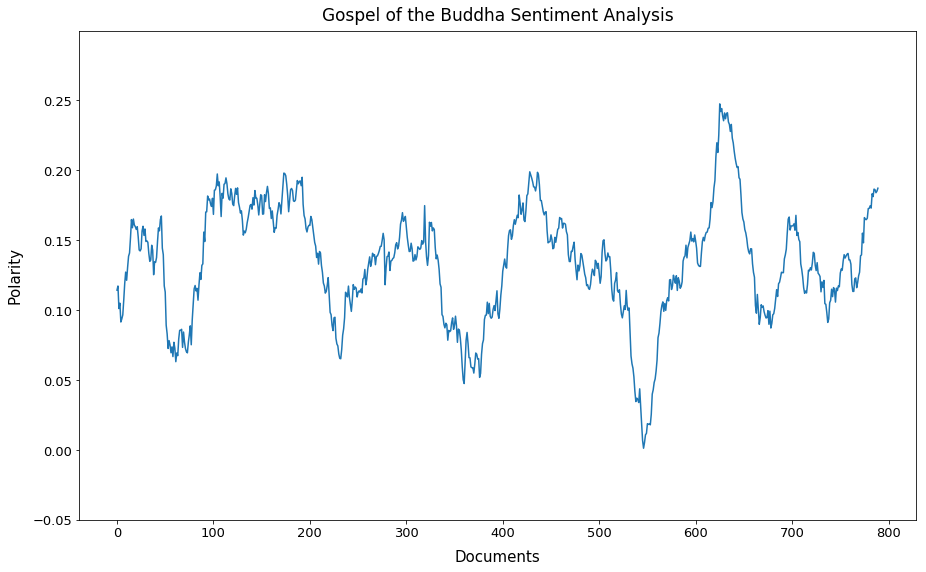

In [105]:
plt.figure(figsize=(15, 9))

axes = plt.axes()
axes.set_ylim([-.05, .30])
axes.set_yticks([-.05, 0, 0.05, 0.1, 0.15, 0.2, 0.25])

plt.plot(buddha_running_mean)
plt.title('Gospel of the Buddha Sentiment Analysis', fontsize=17, pad=10)

plt.xlabel('Documents', fontsize=15, labelpad=10)
plt.ylabel('Polarity', fontsize=15, labelpad=10)

plt.xticks(size=13)
plt.yticks(size=13)

plt.savefig('figures/Buddha_Sentiment_Analysis.png');

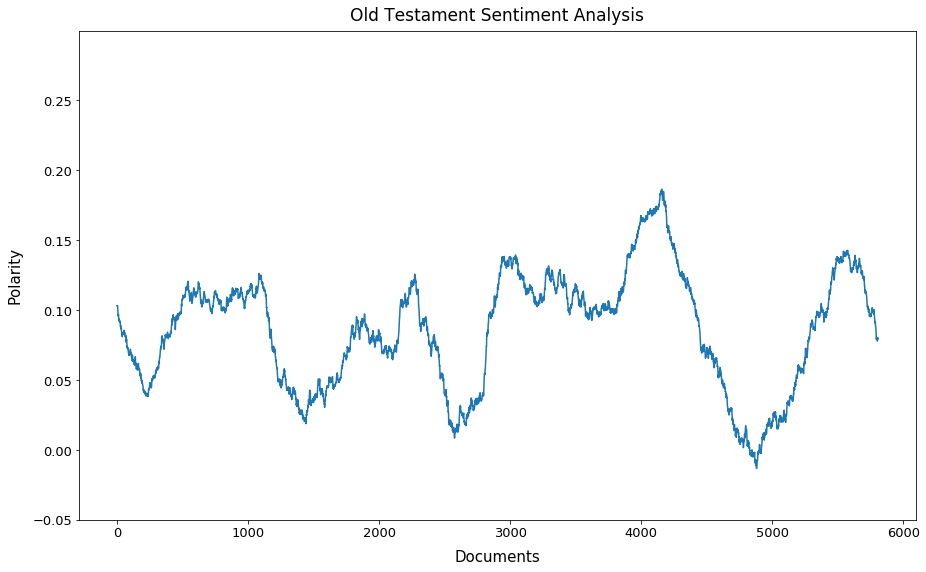

In [104]:
plt.figure(figsize=(15, 9))

axes = plt.axes()
axes.set_ylim([-.05, .30])
axes.set_yticks([-.05, 0, 0.05, 0.1, 0.15, 0.2, 0.25])

plt.plot(old_testament_running_mean)
plt.title('Old Testament Sentiment Analysis', fontsize=17, pad=10)

plt.xlabel('Documents', fontsize=15, labelpad=10)
plt.ylabel('Polarity', fontsize=15, labelpad=10)

plt.xticks(size=13)
plt.yticks(size=13)

plt.savefig('figures/Old_T_Sentiment_Analysis.png');

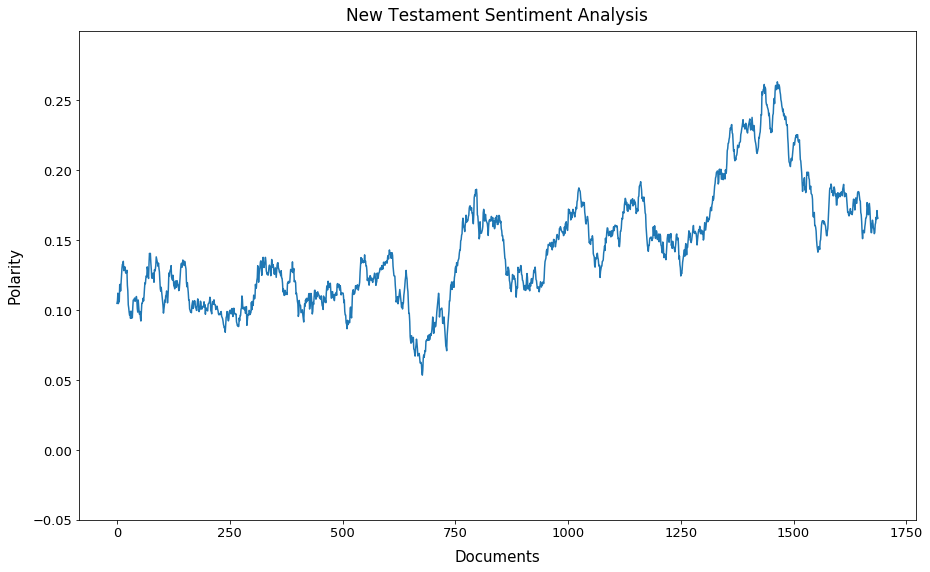

In [101]:
plt.figure(figsize=(15, 9))

axes = plt.axes()
axes.set_ylim([-.05, .30])
axes.set_yticks([-.05, 0, 0.05, 0.1, 0.15, 0.2, 0.25])

plt.plot(new_testament_running_mean)
plt.title('New Testament Sentiment Analysis', fontsize=17, pad=10)

plt.xlabel('Documents', fontsize=15, labelpad=10)
plt.ylabel('Polarity', fontsize=15, labelpad=10)

plt.xticks(size=13)
plt.yticks(size=13)

plt.savefig('figures/New_T_Sentiment_Analysis.png');

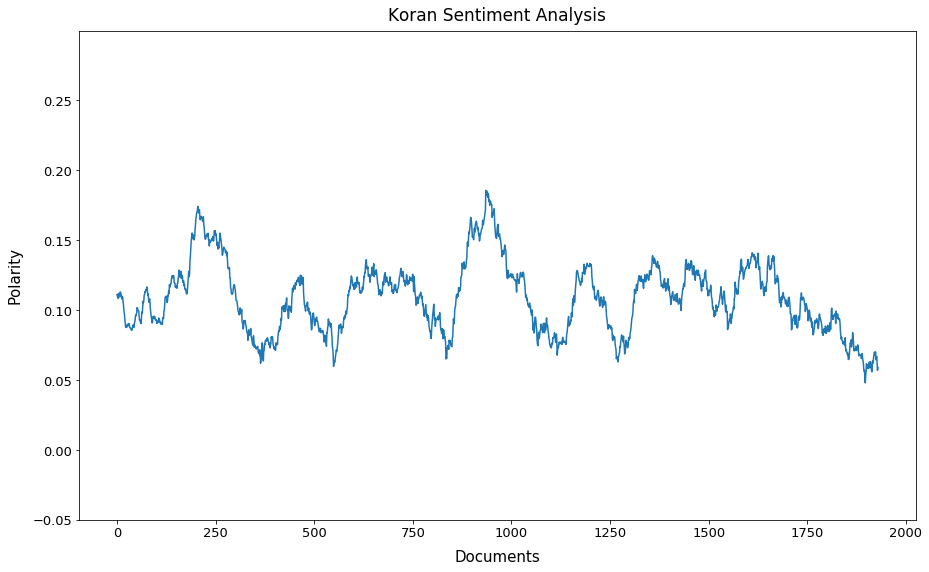

In [102]:
plt.figure(figsize=(15, 9))

axes = plt.axes()
axes.set_ylim([-.05, .30])
axes.set_yticks([-.05, 0, 0.05, 0.1, 0.15, 0.2, 0.25])

plt.plot(koran_running_mean)
plt.title('Koran Sentiment Analysis', fontsize=17, pad=10)

plt.xlabel('Documents', fontsize=15, labelpad=10)
plt.ylabel('Polarity', fontsize=15, labelpad=10)

plt.xticks(size=13)
plt.yticks(size=13)

plt.savefig('figures/Koran_Sentiment_Analysis.png');

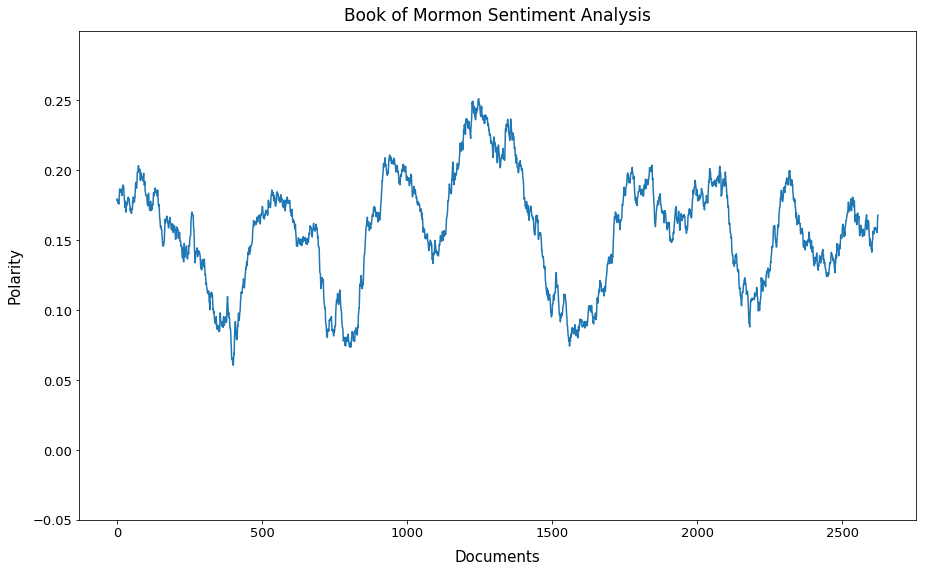

In [103]:
plt.figure(figsize=(15, 9))

axes = plt.axes()
axes.set_ylim([-.05, .30])
axes.set_yticks([-.05, 0, 0.05, 0.1, 0.15, 0.2, 0.25])

plt.plot(mormon_running_mean)
plt.title('Book of Mormon Sentiment Analysis', fontsize=17, pad=10)

plt.xlabel('Documents', fontsize=15, labelpad=10)
plt.ylabel('Polarity', fontsize=15, labelpad=10)

plt.xticks(size=13)
plt.yticks(size=13)

plt.savefig('figures/Mormon_Sentiment_Analysis.png');

## Scatter Text

In [ ]:
buddha_scatter_df = pd.DataFrame(document_list_buddha, columns=['Text'])
buddha_scatter_df['Book'] = 'Gospel of the Buddha'
buddha_scatter_df['Sentiment'] = buddha_polarity

old_testament_scatter_df = pd.DataFrame(document_list_old_testament, columns=['Text'])
old_testament_scatter_df['Book'] = 'Old Testament'
old_testament_scatter_df['Sentiment'] = old_testament_polarity

new_testament_scatter_df = pd.DataFrame(document_list_new_testament, columns=['Text'])
new_testament_scatter_df['Book'] = 'New Testament'
new_testament_scatter_df['Sentiment'] = new_testament_polarity

koran_scatter_df = pd.DataFrame(document_list_koran, columns=['Text'])
koran_scatter_df['Book'] = 'Koran'
koran_scatter_df['Sentiment'] = koran_polarity

mormon_scatter_df = pd.DataFrame(document_list_mormon, columns=['Text'])
mormon_scatter_df['Book'] = 'Book of Mormon'
mormon_scatter_df['Sentiment'] = mormon_polarity

In [ ]:
df = pd.concat([buddha_scatter_df, old_testament_scatter_df, new_testament_scatter_df,
                    koran_scatter_df, mormon_scatter_df])

In [ ]:
# Number of very negative documents in each book (not controlled for length of book)

df[df['Sentiment'] <= -.6]['Book'].value_counts()

In [ ]:
# Number of very positive documents in each book (not controlled for length of book)

df[df['Sentiment'] >= .75]['Book'].value_counts()

In [ ]:
(df.groupby(['Book', 'Sentiment', 'Text'])
 .count()
 .sort_values('Sentiment', ascending=True)
 .head(5)
 .sample(frac=1))

### Buddhism vs Mormonism

In [ ]:
df_buddhism_vs_mormonism = pd.concat([buddha_scatter_df, mormon_scatter_df]).sample(frac=1)

In [ ]:
scatter_text_df_buddhism_vs_mormonism = st.CorpusFromPandas(df_buddhism_vs_mormonism,
                             category_col='Book',
                             text_col='Text',
                             nlp=st.whitespace_nlp_with_sentences
                            ).build().remove_terms(stop_words, ignore_absences=True)

In [ ]:
html_buddhism_vs_mormonism = st.produce_scattertext_explorer(
        scatter_text_df_buddhism_vs_mormonism,
        category='Gospel of the Buddha',
        category_name='Buddhism',
        not_category_name='Mormonism',
        minimum_term_frequency=10,
        pmi_threshold_coefficient=5,
        width_in_pixels=1000,
        )

In [ ]:
open('figures/buddhism_vs_mormonism.html', 'wb').write(html_buddhism_vs_mormonism.encode('utf-8'));

### Old Testament vs. New Testament

In [ ]:
df_old_testament_vs_new_testament = pd.concat([old_testament_scatter_df, new_testament_scatter_df]).sample(frac=1)

In [ ]:
scatter_text_df_old_testament_vs_new_testament = st.CorpusFromPandas(df_old_testament_vs_new_testament,
                             category_col='Book',
                             text_col='Text',
                             nlp=st.whitespace_nlp_with_sentences
                            ).build().remove_terms(stop_words, ignore_absences=True)

In [ ]:
html_old_testament_vs_new_testament = st.produce_scattertext_explorer(
        scatter_text_df_old_testament_vs_new_testament,
        category='Old Testament',
        category_name='Old Testament',
        not_category_name='New Testament',
        minimum_term_frequency=10,
        pmi_threshold_coefficient=5,
        width_in_pixels=1000,
        )

In [ ]:
open('figures/old_testament_vs_new_testament.html', 'wb').write(html_old_testament_vs_new_testament.encode('utf-8'));

### Koran vs. New Testament

In [ ]:
df_koran_vs_new_testament = pd.concat([koran_scatter_df, new_testament_scatter_df]).sample(frac=1)

In [ ]:
scatter_text_df_koran_vs_new_testament = st.CorpusFromPandas(df_koran_vs_new_testament,
                             category_col='Book',
                             text_col='Text',
                             nlp=st.whitespace_nlp_with_sentences
                            ).build().remove_terms(stop_words, ignore_absences=True)

In [ ]:
html_koran_vs_new_testament = st.produce_scattertext_explorer(
        scatter_text_df_koran_vs_new_testament,
        category='Koran',
        category_name='Islam',
        not_category_name='New Testament',
        minimum_term_frequency=10,
        pmi_threshold_coefficient=5,
        width_in_pixels=1000,
        )

In [ ]:
open('figures/koran_vs_new_testament.html', 'wb').write(html_koran_vs_new_testament.encode('utf-8'));

### Koran vs. Buddhism

In [ ]:
df_koran_vs_buddhism = pd.concat([koran_scatter_df, buddha_scatter_df]).sample(frac=1)

In [ ]:
scatter_text_df_koran_vs_buddhism = st.CorpusFromPandas(df_koran_vs_buddhism,
                             category_col='Book',
                             text_col='Text',
                             nlp=st.whitespace_nlp_with_sentences
                            ).build().remove_terms(stop_words, ignore_absences=True)

In [ ]:
html_koran_vs_buddhism = st.produce_scattertext_explorer(
        scatter_text_df_koran_vs_buddhism,
        category='Koran',
        category_name='Islam',
        not_category_name='Buddhism',
        minimum_term_frequency=10,
        pmi_threshold_coefficient=5,
        width_in_pixels=1000,
        )

In [ ]:
open('figures/koran_vs_buddhism.html', 'wb').write(html_koran_vs_buddhism.encode('utf-8'));

### New Testament vs. Mormonism

In [235]:
df_new_testament_vs_mormonism = pd.concat([new_testament_scatter_df, mormon_scatter_df]).sample(frac=1)

In [236]:
scatter_text_df_new_testament_vs_mormonism = st.CorpusFromPandas(df_new_testament_vs_mormonism,
                             category_col='Book',
                             text_col='Text',
                             nlp=st.whitespace_nlp_with_sentences
                            ).build().remove_terms(stop_words, ignore_absences=True)

In [237]:
html_new_testament_vs_mormonism = st.produce_scattertext_explorer(
        scatter_text_df_new_testament_vs_mormonism ,
        category='New Testament',
        category_name='New Testament',
        not_category_name='Mormonism',
        minimum_term_frequency=10,
        pmi_threshold_coefficient=5,
        width_in_pixels=1000,
        )

In [238]:
open('figures/new_testament_vs_mormonism.html', 'wb').write(html_new_testament_vs_mormonism.encode('utf-8'));

### Buddhism vs. Old Testament

In [239]:
df_buddhism_vs_old_testament = pd.concat([buddha_scatter_df, old_testament_scatter_df]).sample(frac=1)

In [240]:
scatter_text_df_buddhism_vs_old_testament = st.CorpusFromPandas(df_buddhism_vs_old_testament,
                             category_col='Book',
                             text_col='Text',
                             nlp=st.whitespace_nlp_with_sentences
                            ).build().remove_terms(stop_words, ignore_absences=True)

In [241]:
html_buddhism_vs_old_testament = st.produce_scattertext_explorer(
        scatter_text_df_buddhism_vs_old_testament,
        category='Gospel of the Buddha',
        category_name='Buddhism',
        not_category_name='Old Testament',
        minimum_term_frequency=10,
        pmi_threshold_coefficient=5,
        width_in_pixels=1000,
        )

In [242]:
open('figures/buddhism_vs_old_testament.html', 'wb').write(html_buddhism_vs_old_testament.encode('utf-8'));

### Koran vs. Mormonism

In [243]:
df_koran_vs_mormonism = pd.concat([koran_scatter_df, mormon_scatter_df]).sample(frac=1)

In [244]:
scatter_text_df_koran_vs_mormonism = st.CorpusFromPandas(df_koran_vs_mormonism,
                             category_col='Book',
                             text_col='Text',
                             nlp=st.whitespace_nlp_with_sentences
                            ).build().remove_terms(stop_words, ignore_absences=True)

In [245]:
html_koran_vs_mormonism = st.produce_scattertext_explorer(
        scatter_text_df_koran_vs_mormonism,
        category='Koran',
        category_name='Islam',
        not_category_name='Mormonism',
        minimum_term_frequency=10,
        pmi_threshold_coefficient=5,
        width_in_pixels=1000,
        )

In [246]:
open('figures/koran_vs_mormonism.html', 'wb').write(html_koran_vs_mormonism.encode('utf-8'));